#### Testing classes for furry-couscous

In [1]:
from fcc_DRs import * # file with dimensionality reduction classes

Using TensorFlow backend.


In [2]:
# read a csv file into an RNA_file object
# this one has cells already in the rows, but no cell ID labels
# it does have gene labels in the 0th row position
test = RNA_counts.from_file(datafile='inputs/Myeloid_with_IDs.csv', labels=[None,0], cells_axis=0)

In [3]:
# this is already feature-selected to 171 genes
test.data.shape

(4423, 171)

In [6]:
# this object has a bunch of useful attributes:
test.data # gives the full data as pd.DataFrame, including cell and gene IDs if available
test.counts # gives the counts matrix as a np.array
test.gene_IDs # this particular dataset has gene IDs

Index(['1100001G20RIK', '1190002H23RIK', '1190007F08RIK', '2210020M01RIK',
       '3110082D06RIK', 'AK084954', 'IGHG1', 'ADSSL1', 'ALAD', 'ALAS1',
       ...
       'TMSB4X', 'TNFAIP2', 'TNNI3', 'TREM3', 'TSPO', 'TYROBP', 'UQCRH',
       'VAMP5', 'VIM', 'ZFPM1'],
      dtype='object', length=171)

In [7]:
# we could use NVR to select features of our dataset
# this method returns another RNA_counts object with only variable genes selected by NVR
test_nvr = RNA_counts.nvr_select(test)

Start min_conn_k
3 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 42.95533514022827 seconds
done

Selected 144 variable genes



In [10]:
# check out the shape and selected gene names
print(test_nvr.data.shape)
test_nvr.gene_IDs

(4423, 144)


Index(['1100001G20RIK', '1190002H23RIK', '1190007F08RIK', '2210020M01RIK',
       'AK084954', 'IGHG1', 'ADSSL1', 'ALAD', 'ALAS1', 'ALAS2',
       ...
       'TMSB4X', 'TNFAIP2', 'TNNI3', 'TREM3', 'TSPO', 'TYROBP', 'UQCRH',
       'VAMP5', 'VIM', 'ZFPM1'],
      dtype='object', length=144)

In [3]:
# we can take a subset of the cells in our dataframe for quicker analysis
# this will be saved into another instance of the RNA_counts class
test1 = RNA_counts.downsample(data=test.data, n_cells=700)
test1.data.shape

(700, 171)

In [9]:
# similarly, we can generate K-fold splits of the original data to train and test DR algorithms
test_split = RNA_counts.kfold_split(test.data, n_splits=4, seed=18) # let's do a 4-fold cross-validation model

In [10]:
# the output of this class method will be a dictionary of RNA_counts objects
# the n_splits 'train' objects should be of length round(n_cells/n_splits, 0)
test_split['train'][0].data.shape

(3317, 171)

In [11]:
# each 'test' set should be of length round(n_cells/n_splits, 0)
test_split['test'][0].data.shape

(1106, 171)

In [4]:
# let's analyze the downsampled dataset, test1, for simplicity, 
# although the RNA_counts objects within the KFold split dictionary can be manipulated in the same way.

# generate PCA object for arcsinh-transformed data with 100 components
%time test1_PCA = fcc_PCA(test1.arcsinh_norm(norm=True, scale=1000), n_components=100)

CPU times: user 156 ms, sys: 23.9 ms, total: 180 ms
Wall time: 115 ms


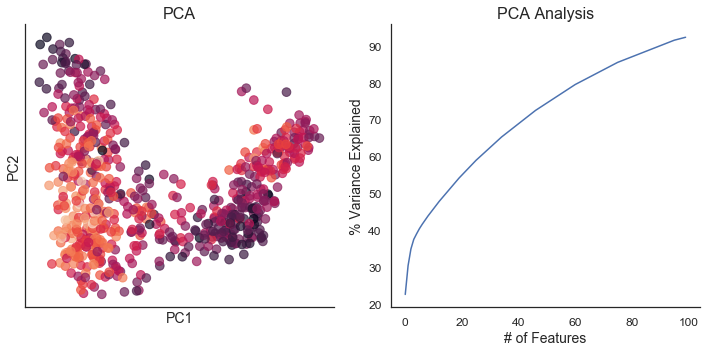

In [5]:
# look at the results
test1_PCA.plot()
# plots are colored by point density in 2D space

In [17]:
# now we can perform a t-SNE on the arcsinh-transformed data...
%time test1_tSNE = fcc_tSNE(test1.arcsinh_norm(norm=True, scale=1000), perplexity=30)

CPU times: user 4.06 s, sys: 27 ms, total: 4.09 s
Wall time: 4.12 s


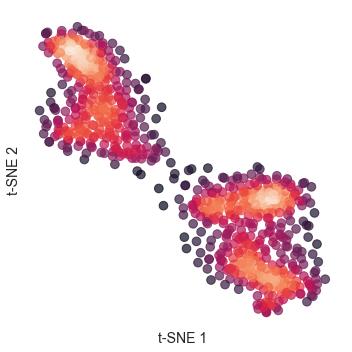

In [18]:
# ... and look at those results
test1_tSNE.plot()

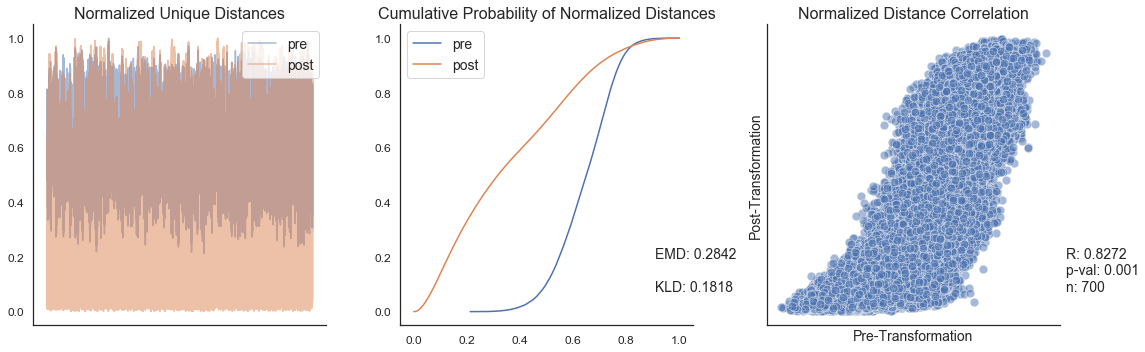

CPU times: user 10.7 s, sys: 795 ms, total: 11.5 s
Wall time: 10.8 s


In [19]:
# each of these DR (dimensionality reduction) objects we've created has a .distance_matrix() method
# we can correlate the Euclidean distances pretty easily:
from fcc_utils import compare_euclid
# let's use another function I wrote to quickly perform statistical tests on the cell-cell distances
%time mantel_stats, EMD, KLD = compare_euclid(pre=test1_PCA.distance_matrix(), post=test1_tSNE.distance_matrix())

This t-SNE is primed with a PCA with 100 components


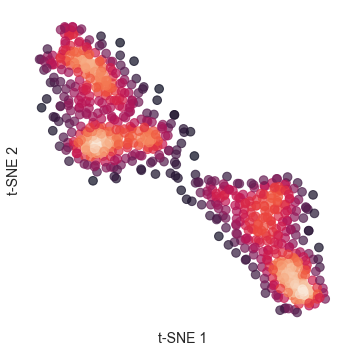

CPU times: user 4.06 s, sys: 62.4 ms, total: 4.12 s
Wall time: 3.98 s


In [20]:
%%time
# we could also create a tSNE primed with our PCA results just as easily with the .results attribute of the PCA object
test1_PCA_tSNE = fcc_tSNE(test1_PCA.results, perplexity=30)
# to check how many components we used in the original PCA, just call the object's attribute
print('This t-SNE is primed with a PCA with {} components'.format(test1_PCA.components))
test1_PCA_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12a666550>)

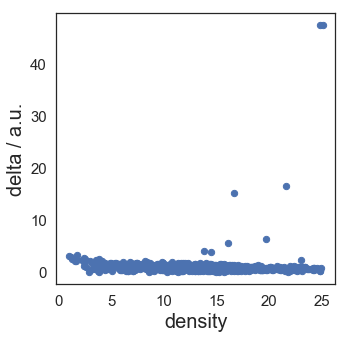

In [21]:
# density-peak clustering is built into the DR objects
# we can look at the decision graph and assign cluster centers 
test1_PCA_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129f4c208>)

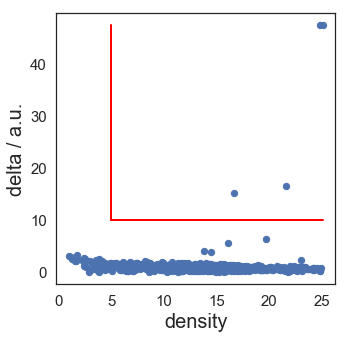

In [22]:
# now, if we assign cutoffs for density and delta, we can generate cluster membership for our tSNE
test1_PCA_tSNE.clu.assign(5,10)
test1_PCA_tSNE.clu.draw_decision_graph(min_delta=test1_PCA_tSNE.clu.min_delta, min_density=test1_PCA_tSNE.clu.min_density)

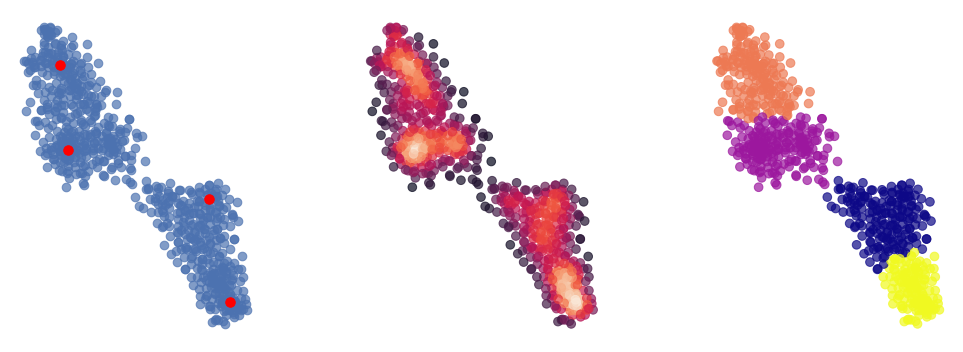

In [23]:
# finally, we can look at the clusters in our tSNE
test1_PCA_tSNE.plot_clusters()

In [24]:
# silhouette score is automatically calculated as well
test1_PCA_tSNE.silhouette_score

0.5057505

In [25]:
# this object has cluster membership for each cell built in now:
test1_PCA_tSNE.clu.membership

array([0, 2, 1, 2, 2, 3, 0, 1, 2, 2, 0, 2, 3, 2, 2, 1, 1, 1, 0, 2, 2, 1,
       3, 0, 1, 0, 2, 0, 2, 1, 2, 3, 1, 1, 1, 0, 1, 0, 3, 1, 2, 3, 3, 0,
       1, 2, 3, 1, 3, 3, 0, 1, 1, 1, 3, 2, 1, 0, 2, 3, 2, 3, 1, 3, 0, 2,
       2, 3, 3, 3, 1, 2, 3, 2, 2, 3, 2, 1, 0, 1, 3, 3, 0, 2, 1, 0, 2, 0,
       3, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2, 3, 0,
       2, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 3, 1, 3, 2, 0, 1, 0, 0, 1, 3, 1,
       3, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 3, 3, 0, 3, 0, 2, 0, 1, 0, 0,
       0, 1, 2, 0, 2, 2, 2, 2, 1, 3, 1, 2, 0, 0, 3, 2, 0, 1, 0, 1, 1, 1,
       3, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0, 1, 2, 3, 2, 3, 3, 1, 0, 3, 0, 0,
       3, 3, 2, 0, 3, 3, 0, 2, 2, 2, 0, 1, 1, 1, 3, 0, 1, 0, 1, 3, 0, 1,
       2, 2, 1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 0, 1, 3, 0, 1, 0, 2, 3, 2, 2,
       0, 0, 0, 0, 1, 3, 2, 3, 1, 3, 3, 0, 1, 0, 3, 0, 2, 3, 0, 2, 2, 0,
       2, 2, 2, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 3, 1, 0,
       1, 2, 3, 2, 0, 1, 1, 0, 2, 3, 1, 1, 0, 1, 1,

In [6]:
# if you try to plot clusters without assigning cutoffs, it won't work
# let's try with the original PCA object, which we have not clustered yet:
test1_PCA.plot_clusters()

Clustering not yet determined. Assign clusters with self.clu.assign().

